# Inventory dynamics problem with deterministic demand

This notebook should serve as a sandbox for running the code from the lecture notes on inventory dynamics with deterministic demand.

### Tasks

1. Copy over teh code from the lecture notes
1. Make sure you understand every line of the code
1. Run the code with various specifications and parameter values
1. Compare the solutions of several specifications ("play with the model")


In [1]:
# Here is the first cell already copied over for you

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

class inventory_model:
    '''Small class to hold model fundamentals and its solution'''

    def __init__(self,label='noname',
                 max_inventory=10,  # upper bound on the state space
                 c = 3.2,           # fixed cost of order
                 p = 2.5,           # profit per unit of good
                 r = 0.5,           # storage cost per unit of good
                 β = 0.95,          # discount factor
                 demand = 4         # fixed demand
                 ):
        '''Create model with default parameters'''
        self.label=label # label for the model instance
        self.c, self.p, self.r, self.β = c, p, r, β
        self.demand = demand
        # created dependent attributes (it would be better to have them updated when underlying parameters change)
        self.n = max_inventory+1    # number of inventory levels
        self.upper = max_inventory  # upper boundary on inventory
        self.x = np.arange(self.n)  # all possible values of inventory (state space)

    def __repr__(self):
        '''String representation of the model'''
        return 'Inventory model labeled "{}"\nParamters (c,p,r,β) = ({},{},{},{})\nDemand={}\nUpper bound on inventory {}' \
               .format (self.label,self.c,self.p,self.r,self.β,self.demand,self.upper)

    def sales(self,x,d):
        '''Sales in given period'''
        return np.minimum(x,d)

    def next_x(self,x,d,q):
        '''Inventory to be stored, becomes next period state'''
        return x - self.sales(x,d) + q

    def profit(self,x,d,q):
        '''Profit in given period'''
        return self.p * self.sales(x,d) - self.r * self.next_x(x,d,q) - self.c * (q>0)

In [ ]:
model=inventory_model(label='test')
print(model)

q=np.zeros(model.n)
print('Current profits with zero orders\n',model.profit(model.x,model.demand,q))

Inventory model labeled "test"
Paramters (c,p,r,β) = (3.2,2.5,0.5,0.95)
Demand=4
Upper bound on inventory 10
Current profits with zero orders
 [ 0.   2.5  5.   7.5 10.   9.5  9.   8.5  8.   7.5  7. ]


What should come out by default:

Inventory model labeled "test"

Paramters (c,p,r,β) = (3.2,2.5,0.5,0.95)

Demand=4

Upper bound on inventory 10

Current profits with zero orders

 [ 0.   2.5  5.   7.5 10.   9.5  9.   8.5  8.   7.5  7. ]

In [9]:
# illustration of broadcasting in the inventory model
q=model.x[:,np.newaxis]  # column vector
print('Current inventory\n',model.x)
print('Current sales\n',model.sales(model.x,model.demand))
print('Current orders\n',q)
print('Next period inventory\n',model.next_x(model.x,model.demand,q))
print('Current profits\n',model.profit(model.x,model.demand,q))

Current inventory
 [ 0  1  2  3  4  5  6  7  8  9 10]
Current sales
 [0 1 2 3 4 4 4 4 4 4 4]
Current orders
 [[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
Next period inventory
 [[ 0  0  0  0  0  1  2  3  4  5  6]
 [ 1  1  1  1  1  2  3  4  5  6  7]
 [ 2  2  2  2  2  3  4  5  6  7  8]
 [ 3  3  3  3  3  4  5  6  7  8  9]
 [ 4  4  4  4  4  5  6  7  8  9 10]
 [ 5  5  5  5  5  6  7  8  9 10 11]
 [ 6  6  6  6  6  7  8  9 10 11 12]
 [ 7  7  7  7  7  8  9 10 11 12 13]
 [ 8  8  8  8  8  9 10 11 12 13 14]
 [ 9  9  9  9  9 10 11 12 13 14 15]
 [10 10 10 10 10 11 12 13 14 15 16]]
Current profits
 [[ 0.   2.5  5.   7.5 10.   9.5  9.   8.5  8.   7.5  7. ]
 [-3.7 -1.2  1.3  3.8  6.3  5.8  5.3  4.8  4.3  3.8  3.3]
 [-4.2 -1.7  0.8  3.3  5.8  5.3  4.8  4.3  3.8  3.3  2.8]
 [-4.7 -2.2  0.3  2.8  5.3  4.8  4.3  3.8  3.3  2.8  2.3]
 [-5.2 -2.7 -0.2  2.3  4.8  4.3  3.8  3.3  2.8  2.3  1.8]
 [-5.7 -3.2 -0.7  1.8  4.3  3.8  3.3  2.8  2.3  1.8  1.3]
 [-6.2 -3.7 -1.2  1.3  3.8  3.3  2.8  2

## Backwards induction algorithm to solve the finite horizon model

Solver for the finite horizon dynamic programming problems

1. Start at t=T (T=last period)
1. Solve Bellman equation at t, record optimal choice  
1. Decrease t unless t=1, and return to previous step.  


As result, for all t=1,..,T have found the optimal choice (as a function of state)

### Define the Bellman equation

In [ ]:
# Function that gets us the bellman equation based on m (), v0 (initial value)
def bellman(m,v0):
    '''Bellman equation for inventory model
       Inputs: model object
               next period value function
    '''
    # create the grid of choices (same as x), column-vector
    q = m.x[:,np.newaxis]
    # compute current period profit (relying on numpy broadcasting to get the matrix with choices in rows)
    p = m.profit(m.x,m.demand,q)
    # indexes for next period value with extrapolation using last value
    i = np.minimum(m.next_x(m.x,m.demand,q),m.upper)
    # compute the Bellman maximand
    vm = p + m.β*v0[i]
    # find max and argmax
    v1 = np.amax(vm,axis=0)   # maximum in every column
    q1 = np.argmax(vm,axis=0) # arg-maximum in every column = order volume
    return v1, q1

### Initial V (?)

In [11]:
v = np.zeros(model.n)
for i in range(3):
    v,q = bellman(model,v)
    print('Value =',v,'Policy =',q,sep='\n',end='\n\n')

Value =
[ 0.   2.5  5.   7.5 10.   9.5  9.   8.5  8.   7.5  7. ]
Policy =
[0 0 0 0 0 0 0 0 0 0 0]

Value =
[ 4.3    6.8    9.3   11.8   14.3   14.3   14.3   15.625 17.5   16.525
 15.55 ]
Policy =
[4 4 4 4 4 3 2 0 0 0 0]

Value =
[ 9.425 11.925 14.425 16.925 19.425 19.425 19.425 19.71  21.585 21.085
 20.585]
Policy =
[8 8 8 8 8 7 6 0 0 0 0]



### Define function for backward induction

In [17]:
def solver_backwards_induction(m,T=10,verbose=False):
    '''Backwards induction solver for the finite horizon case'''
    # solution is time dependent
    m.value  = np.zeros((m.n,T))
    m.policy = np.zeros((m.n,T))
    # main DP loop (from T to 1)
    for t in range(T,0,-1):
        if verbose:
            print('Time period %d\n'%t)
        j = t-1 # index of value and policy functions for period t
        if t==T:
            # terminal period: ordering zero is optimal
            m.value[:,j] = m.profit(m.x,m.demand,np.zeros(m.n))
            m.policy[:,j] = np.zeros(m.n)
        else:
            # all other periods
            m.value[:,j], m.policy[:,j] = bellman(m,m.value[:,j+1]) # next period to Bellman
        if verbose:
            print(m.value,'\n')
    # return model with updated value and policy functions
    return m

In [16]:

model = inventory_model(label = 'illustration')
model = solver_backwards_induction(model, T = 5, verbose = True)
print('Optimal policy:\n', model.policy)

Time period 5

[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   2.5]
 [ 0.   0.   0.   0.   5. ]
 [ 0.   0.   0.   0.   7.5]
 [ 0.   0.   0.   0.  10. ]
 [ 0.   0.   0.   0.   9.5]
 [ 0.   0.   0.   0.   9. ]
 [ 0.   0.   0.   0.   8.5]
 [ 0.   0.   0.   0.   8. ]
 [ 0.   0.   0.   0.   7.5]
 [ 0.   0.   0.   0.   7. ]] 

Time period 4

[[ 0.     0.     0.     4.3    0.   ]
 [ 0.     0.     0.     6.8    2.5  ]
 [ 0.     0.     0.     9.3    5.   ]
 [ 0.     0.     0.    11.8    7.5  ]
 [ 0.     0.     0.    14.3   10.   ]
 [ 0.     0.     0.    14.3    9.5  ]
 [ 0.     0.     0.    14.3    9.   ]
 [ 0.     0.     0.    15.625  8.5  ]
 [ 0.     0.     0.    17.5    8.   ]
 [ 0.     0.     0.    16.525  7.5  ]
 [ 0.     0.     0.    15.55   7.   ]] 

Time period 3

[[ 0.     0.     9.425  4.3    0.   ]
 [ 0.     0.    11.925  6.8    2.5  ]
 [ 0.     0.    14.425  9.3    5.   ]
 [ 0.     0.    16.925 11.8    7.5  ]
 [ 0.     0.    19.425 14.3   10.   ]
 [ 0.     0.    19.425 14.3    9.

### Plot the solution

In [19]:
def plot_solution(model):
    plt.step(model.x,model.value)
    plt.legend([f'{i+1}' for i in range(model.value.shape[1])])
    plt.title('Value function')
    plt.show()
    plt.step(model.x,model.policy)
    plt.legend([f'{i+1}' for i in range(model.policy.shape[1])])
    plt.title('Policy function (optimal order sizes)')
    plt.show()
#plot_solution(model)

### Play with model and see changes

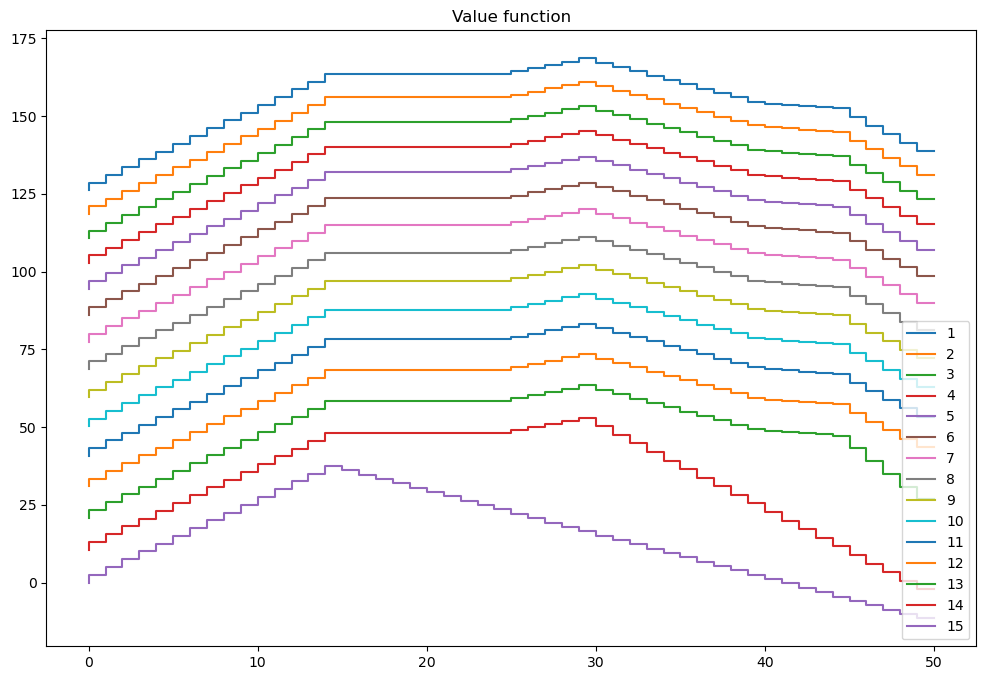

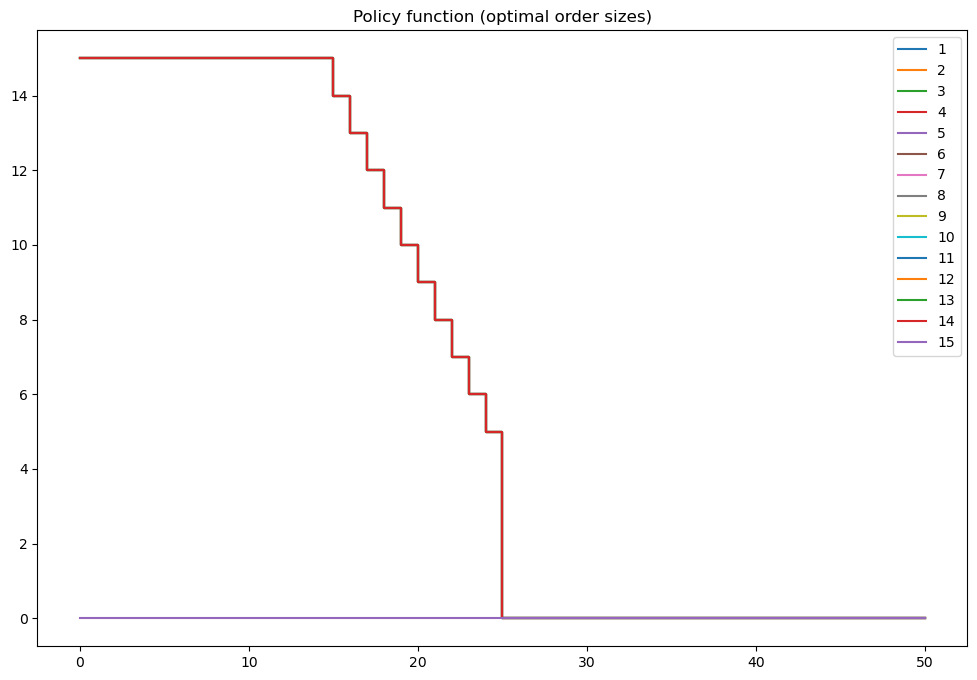

In [ ]:
# We defined a class inventory_model before with initial values
# mod is just another object of that class with different values
mod = inventory_model(label='production',max_inventory=50)
mod.demand = 15 # Fixed demand level
mod.c = 5       # Fixed cost of order (e.g. shipping invariant with order size)
mod.p = 2.5     # Profit per sold unit (i.e. not mirroring directly order cost)
mod.r = 1.4     # storage cost per unit
mod.β = 0.975   # discount factor
mod = solver_backwards_induction(mod,T=15)
plot_solution(mod)